# NMF Practical Work

**Umut Simsekli** 

Telecom Paris

## 1. Factorisation en matrices positives avec les $\beta$-divergences

$$
\begin{aligned}
\left ( {W*}, {H*} \right ) &= argmin_{W \leq 0, H \leq 0} \sum_{i=1}^{I} \sum_{j=1}^J d_{\beta}(x_{ij} || \hat{x}_{ij})
\\
\end{aligned}
$$
$$
\begin{aligned}
S &= \sum_{i=1}^{I} \sum_{j=1}^J d_{\beta}(x_{ij} || \hat{x}_{ij})
\\
&= \sum_{i=1}^{I} \sum_{j=1}^J d_{\beta}(x_{ij} || \hat{x}_{ij})
\\
\frac{\partial d_{\beta}(x_{ij} || \hat{x_{ij}})}{\partial w_{ik}} &= \hat{x}_{ij}^{\beta -1} - x_{ij}\hat{x_{ij}}^{\beta - 2}
\\
\frac{\partial d_{\beta}(x || \hat{x})}{\partial w_{ik}} &= \sum_{J=1}^{J} h_{kj} \left ( \hat{x}_{ij}^{\beta -1} - x_{ij}\hat{x_{ij}}^{\beta  - 2} \right )
\\
&= \left ( \sum_{j=1}^{J} h_{kj} \hat{x}_{ij}^{\beta - 1} \right ) - \left ( \sum_{j=1}^{J} h_{kj} x_{ij} \hat{x}{ij}^{\beta - 2} \right )
&= p_{ik} - m_{ik}
\end{aligned}
$$
Avec $p_{ik}, m_{ik} \geq 0$, on sait mettre à jour $W$ et $H$ de la sorte :
$$
\begin{aligned}
w_{ik} & \leftarrow w_{ik} \frac{m_{ik}}{p_{ik}}
\\
w_{ik} & \leftarrow w_{ik} \frac{\sum_{j=1}^{J} x_{ij}\hat{x_{ij} }^{\beta - 2} h_{kj}}{\sum_{j=1}^{J} \hat{x}_{ij}^{\beta -1} h_{kj}}
\\
h_{kj} & \leftarrow h_{kj} \frac{\sum_{i=1}^{I} x_{ij}\hat{x_{ij} }^{\beta - 2} w_{ik}}{\sum_{i=1}^{I} \hat{x}_{ij}^{\beta -1} w_{ik}}
\end{aligned}
$$

Pour pallier des problèmes numériques quand $W \rightarrow 0$ et $H \rightarrow +\infty$ :
$$
\begin{aligned}
r_k &= ||w_{.k}||
\\
w_{.k} &\leftarrow w_{.k}/r_k
\\
h_{k.} &\leftarrow h_{k.} r_k
\end{aligned}
$$

## 2. Variantes autour d'un exemple simple

### 2. 1 Construction de l'exemple simple

In [61]:
import os
import re
import numpy as np
import numpy.typing as npt
rng = np.random.default_rng()
import scipy.signal as sig

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display as ipd

# Librosa for audio
import librosa
# # And the display module for visualization
import librosa.display

from typing import Callable, Tuple, List, Dict

<Figure size 432x288 with 0 Axes>

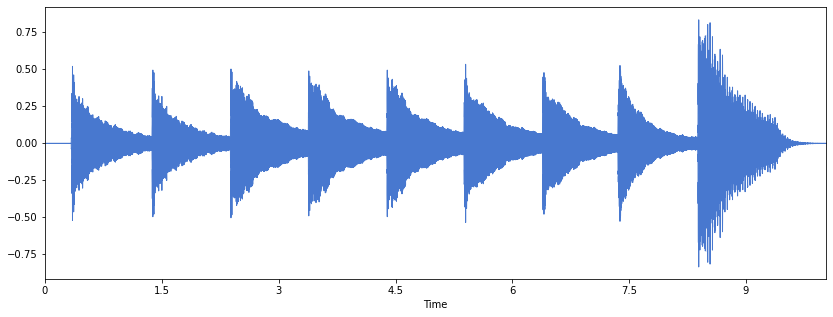

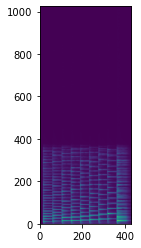

In [3]:
# Audio file
data_path = '../data'
file_name = 'Cmajor_piano8khz.wav'
file_path = os.path.join(data_path, file_name)

# Load signal
y, sr = librosa.load(file_path)

# Compute STFT
Xstft = librosa.stft(y, n_fft=2048, hop_length=512, win_length=None)
X = np.abs(Xstft)

#Visualize the waveform
plt.figure()
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

#Visualize the spectrum
plt.figure()
plt.imshow(X**0.3)
plt.gca().invert_yaxis()


In [4]:
# Use Wiener filtering to reconstruct each note separately


# Example reconstruction
y_hat = librosa.istft(Xstft)
ipd.Audio(y_hat, rate=sr)


### 2. 1 Construction de l'exemple simple

On doit choisir la fenêtre de Hann (largueur $\frac{4}{M}$ dans Fourier)
avec une longueur temporelle $M$ telle que l'on ait :
$$
\begin{aligned}
\frac{4}{M} &= \frac{80}{f_e}
\iff M &= \frac{4 f_e}{80}
\end{aligned}
$$
Pour chaque fréquence fondamentale $f_0$, on a un harmonique maximum $h_{max}$
que l'on peut consider,
(en négligeant la largeur de la fenêtre) tel que :
$$
\begin{aligned}
h f_0 & \leq \frac{f_e}{2}
\\
\iff h & \leq \frac{f_e}{2 f_0}
\\
\implies h_{max} &= \left \lfloor \frac{f_e}{2 f_0} \right \rfloor
\end{aligned}
$$

De plus :
$$
\begin{aligned}
\Delta T &= \frac{I_{pas}}{f_e} = 0.5s
\\
M_h &= \frac{4 I_{pas}}{3}
\\
\implies I_{pas} &= \frac{f_e}{2}
\\
M_h &= \frac{2 f_e}{3}
\\
\end{aligned}
$$

(2, 5333)


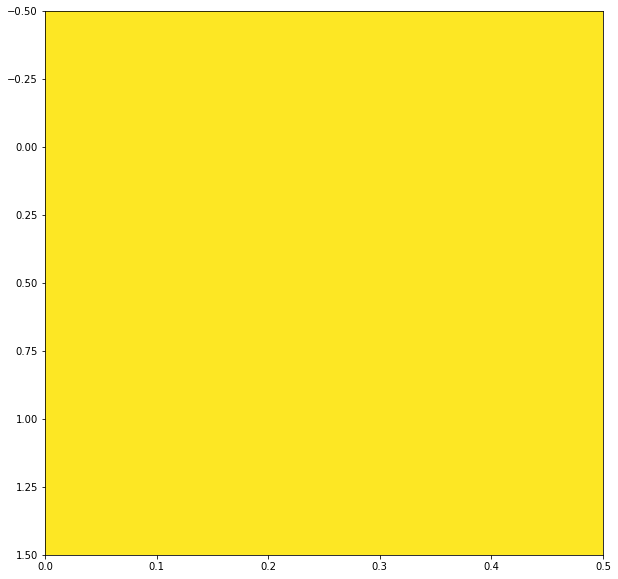

In [5]:
def harmonic_spectrum_init(win: npt.NDArray[float], nu_ks: npt.NDArray[float], a_hs: List[npt.NDArray[float]], n_fft: int) -> npt.NDArray[np.complex128]:
    m = win.shape[0]
    nb_keys = nu_ks.shape[0]
    w_r = np.empty((n_fft, nb_keys), dtype=np.complex128)
    for k, a_ks, in enumerate(a_hs):
        nu_k = nu_ks[k]
        kk, tt = np.meshgrid(np.arange(a_ks.shape[0]), np.arange(m))
        z_shifts = a_ks[kk] * np.exp(2j * np.pi * (1 + kk) * nu_k * tt)
        # Modulate the window by a chosen complex exponential
        # So that each harmonic is added at the appropriate frequency
        # print(win_shifts.shape)
        win_shifts = z_shifts * win[..., np.newaxis]
        win_sum = np.sum(win_shifts, axis=-1)
        w_r[:, k] = np.fft.fft(win_sum, n=n_fft)
    return w_r

def activation_init(h: npt.NDArray[float], bs: npt.NDArray[float], nb_frames: int, step: int, m: int) -> npt.NDArray[float]:
    nb_keys = bs.shape[0]
    nb_strokes = bs.shape[1]
    l_stroke = h.shape[0]
    t_max = l_stroke * nb_strokes
    x_h_r = np.zeros((nb_keys, t_max))
    for r in np.arange(nb_keys):
        for s in np.arange(nb_strokes):
            x_h_r[r, l_stroke*s:l_stroke*(s+1)] += bs[r, s] * h
    #
    h_r = np.zeros((nb_keys, nb_frames))
    for r in np.arange(nb_keys):
        for p in np.arange(nb_frames):
            frame_start = step * p
            frame_stop = frame_start + m
            h_r[r, p] += np.sum(x_h_r[frame_start:frame_stop])
    return h_r


f_s = 8000  # Hz
n_fft = 512

nu_ks = np.power(2, np.array([-9, -5]) / 12) * 440 / f_s
#nu_ks = nu_ks[:1]
#print(nu_ks)
alpha = 10
h_maxs = np.floor(1 / (2*nu_ks))
a_hs = [np.exp(-alpha * np.arange(h_max)/h_max) for h_max in h_maxs]
#print(h_maxs*nu_ks)

win_w = 80 / f_s
m_w =  int(4 / win_w)
win = sig.windows.hann(m_w, sym=False)
#
w_r = harmonic_spectrum_init(win, nu_ks, a_hs, n_fft)

delta_t = 0.5 # s
step = int(delta_t * f_s)
m_h = int(4*step/3)
tau = step / 3
h = np.exp(- np.arange(delta_t * f_s) / tau)
nb_frames = 1000
bs = rng.integers(low=0, high=2, size=(nu_ks.shape[0], m_h)).astype(float)
#
h_r = activation_init(h, bs, nb_frames, step, m_h)

freqs = np.fft.fftfreq(n_fft)

plt.figure(figsize=(10, 10))
plt.xlim(0., 0.5)
# plt.plot(np.fft.fftshift(freqs), np.abs(np.fft.fftshift(w_r[:, 1])))
# plt.imshow(np.abs(w_r), aspect='auto')
# plt.imshow(np.abs(w_r @ h_r), aspect='auto')
print(bs.shape)
plt.imshow(bs[:, 10:20], aspect='auto')

### 2.2 NMF classique

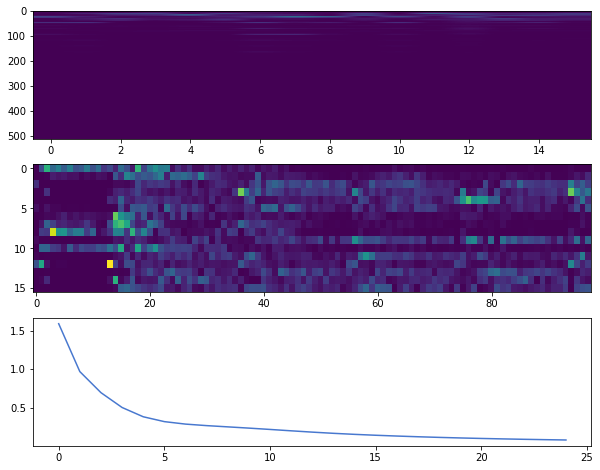

In [81]:
def update_harmonic_spectrum(x: npt.NDArray[float], w: npt.NDArray[float], h: npt.NDArray[float], beta: float) -> npt.NDArray[float]: 
    x_hat = w @ h
    x_hat_pow_2 = np.power(x_hat, beta-2)
    x_hat_pow_1 = x_hat_pow_2 * x_hat
    return w * ((x * x_hat_pow_2) @ h.T) / (x_hat_pow_1 @ h.T)

def nmf_update(x: npt.NDArray[float], w: npt.NDArray[float], h: npt.NDArray[float], beta: float, nb_it: int = 1, cb=Callable) -> Tuple[npt.NDArray[float], npt.NDArray[float]]: 
    for it in range(nb_it):
        w = update_harmonic_spectrum(x, w, h, beta)
        h = update_harmonic_spectrum(x.T, h.T, w.T, beta).T
        if cb:
            cb(x, w, h, beta, it)
    return w, h

def nmf(x: npt.NDArray[float], beta: float, k: int, w_init: npt.NDArray[float] = None, h_init: npt.NDArray[float] = None, nb_it: int = 1, cb: Callable = None) -> Tuple[npt.NDArray[float], npt.NDArray[float]]:
    assert np.min(x) >= 0
    gaussian = True
    mu = np.sqrt(np.mean(x))
    if gaussian:
        sigma = np.std(x)/2
        assert mu > 0
        make_random = lambda size: np.abs(np.random.normal(loc=mu, scale=sigma, size=size))
    else:
        make_random = lambda size: rng.random(size=size)
    w = make_random(x.shape[:-1] + (k,)) if w_init is None else w_init
    h = make_random((k,x.shape[-1])) if h_init is None else h_init
    return nmf_update(x, w, h, beta, nb_it=nb_it, cb=cb)

def beta_div_cost(x: npt.NDArray[float], w: npt.NDArray[float], h: npt.NDArray[float], beta: float) -> float:
    x_hat = w @ h
    x_norm = np.linalg.norm(x)
    x_hat_norm = np.linalg.norm(x_hat)
    div = None
    if beta == 1: # Kullback-Leibler
        div = x_norm*np.log(x/x_hat) - x + x_hat
    elif beta == 0: # Itakura-Saito
        div = x/x_hat - np.log(x/x_hat) - 1
    else:
        div = x ** beta / (beta * (beta - 1)) - (x * x_hat ** (beta - 1))  / (beta - 1) + x_hat ** beta / beta
    cost = np.linalg.norm(div)/len(div)
    return cost

def nmf_callback(cost: npt.NDArray[float]):
    def cb(x: npt.NDArray[float], w: npt.NDArray[float], h: npt.NDArray[float], beta: float, it: int) -> float:
        cost = beta_div_cost(x, w, h, beta)
        # print(f"It {it} -- cost: {cost}")
        costs[it] = cost
    return cb

data_path = '../data'
file_name = 'chopin.wav'
file_path = os.path.join(data_path, file_name)

s, sr = librosa.load(file_path)
t_start = 50000
t_stop = 100000
x = s[t_start:t_stop]
# x = s

n_fft = 1024
step = 512

x_tilde = librosa.stft(x, n_fft=n_fft, hop_length=step, win_length=None)

k = 16
beta = 2 #KL-divergence
nb_it = 25

costs = np.empty(nb_it)


w, h = nmf(np.abs(x_tilde), 
    beta=beta, 
    k=k,
    nb_it=nb_it,
    cb=nmf_callback(costs)
)


plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.imshow(w, aspect='auto')
plt.subplot(3, 1, 2)
plt.imshow(h, aspect='auto')
plt.subplot(3, 1, 3)
plt.plot(costs)



On constate que la fonction de coût converge,
c'est un indicateur de convergence de l'algorithme NMF.

### 2.3 Variantes

- Après un nombre d'itération suffisant,
on ne remarque pas de différence de résultat
en fonction de l'initialisation.
En effet, le problème est convexe pour $WH$,
et cette propriété se conserve par
optimisation jointe de $(W, H)$.
On remarque cependant que les 
valeurs de ($W$, $H$) peuvent exploser
et provoquer une instabilité numérique.

- La matrice d'activation semble de meilleure qualité pour $\beta=\{0;1\}$,
ce qui correspond aux divergences,
plutôt que la distance Euclidienne.
On sait que cette dernière est beaucoup
plus sensible à la dynamique de jeu,
très présente dans une pièce de musique
réelle.
La divergence d'Itakura-Saito semble être la plus rapide à converger.

- Les résultats sur les sons synthétiques
sont très bons, les activations sont nettes.

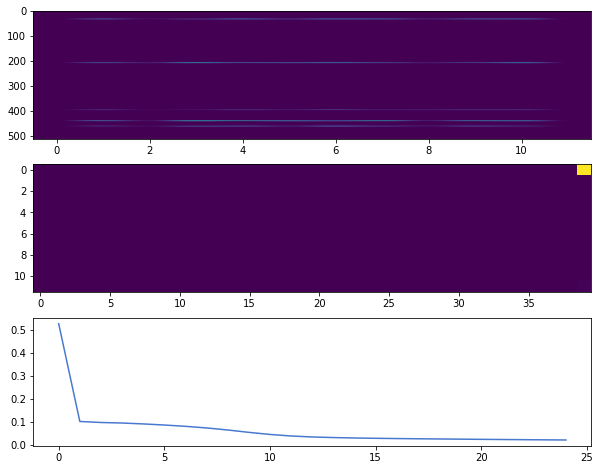

In [58]:
s, sr = librosa.load(file_path)
t_start = 10000
t_stop  = 30000
#x = s[t_start:t_stop]
nb_sines = 6
ts = np.arange(t_stop - t_start)
ts = np.broadcast_to(ts, (nb_sines,) + ts.shape)
amps = rng.normal(loc=0.5, scale=0.5, size=nb_sines)
amps = np.tile(amps[..., np.newaxis], (1, ts.shape[1]))
nus = rng.uniform(size=nb_sines) - 0.5
nus = np.tile(nus[..., np.newaxis], (1, ts.shape[1]))
x = np.sum(amps * np.cos(2 * np.pi *  nus * ts), axis=0)

n_fft = 1024
step = 512

x_tilde = librosa.stft(x, n_fft=n_fft, hop_length=step, win_length=None)
k = 12
beta = 0 #Itakura-Saito divergence
#beta = 1 #Kullback-Leibler divergence
#beta = 2 #Squared Euclidean distance
nb_it = 25

costs = np.empty(nb_it)

w, h = nmf(np.abs(x_tilde), 
    beta=beta, 
    k=k,
    nb_it=nb_it,
    cb=nmf_callback(costs)
)


plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.imshow(w, aspect='auto')
plt.subplot(3, 1, 2)
plt.imshow(h, aspect='auto')
plt.subplot(3, 1, 3)
plt.plot(costs)
#plt.imshow(np.abs(x_tilde), aspect='auto')
#plt.plot(x)

## 3. Transcription automatique à l'aide de NMF semi-supervisée



0.24690186768133487
[[ 0  1]
 [ 0 13]
 [ 1 14]
 [ 2 94]]


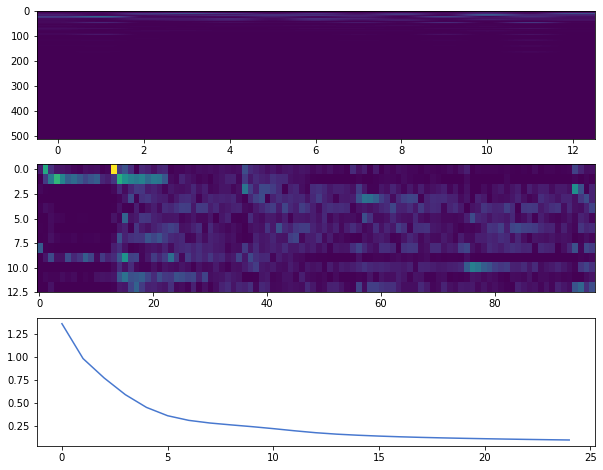

In [105]:

"""
function x = build_signal(notes,Fs)

pitch = notes(1,:);
ton = notes(2,:);
deltaT = notes(3,:);
vel = notes(4,:);

Nnotes = length(pitch);
Lsig = floor((ton(end)+deltaT(end))*Fs);
x = zeros(1,Lsig);

for n=1:Nnotes
    
    % Get midi index
    ind_pitch = pitch(n);
    Lnote = floor(deltaT(n)*Fs);
        
    % Read piano note
    [xt,Fs_old] = audioread(strcat('data/',int2str(ind_pitch),'.wav'));
    xt = resample(xt,Fs,Fs_old)';
    xt = xt(1:Lnote) * vel(n);

    % Fill the current melodic line
    deb = ton(n)*Fs+1  ;  fin = deb + Lnote-1;
    x(deb:fin) = x(deb:fin) + xt;
end

end
"""

def get_key_dict(path: str, pat: re.Pattern) -> Dict[int, Tuple[npt.NDArray[float], float]]:
    keys = dict()
    for file in os.listdir(path):
        m = re.match(pat, file)
        if m is not None:
            key = int(m.groupdict()['key'])
            s, sr = librosa.load(os.path.join(path, file))
            keys[key] = s, sr
    return keys

def get_key_harmonic_spectrum(key_dict: Dict[int, Tuple[npt.NDArray[float], float]], n_fft: int) -> npt.NDArray[float]:
    nb_keys = len(key_dict.keys())
    min_key = min(key_dict.keys())
    w = np.empty((n_fft//2+1, nb_keys))
    for key, (s, sr) in key_dict.items():
        r = key - min_key
        w[:, r] = np.abs(np.fft.rfft(s, n=n_fft))
    return w

def get_test_signal(key_dict: Dict[int, Tuple[npt.NDArray[float], float]], keys: npt.NDArray[int], delta_n: int) -> npt.NDArray[float]:
    x = np.zeros(keys.shape[0] * delta_n)
    for idx, key in np.ndenumerate(keys):
        i = idx[0]
        s, sr = key_dict[key]
        x[i * delta_n: (i+1) * delta_n] = s[:delta_n]
    return x

def detect_attacks(h: npt.NDArray[float], threshold: float) -> List[List[int]]:
    """Uses instant derivate

    Args:
        h (npt.NDArray[float]): [description]
        threshold (float): [description]

    Returns:
        List[npt.NDArray[int]: [description]
    """
    h_norm = h / np.linalg.norm(h)
    dh_dn = h_norm - np.roll(h_norm, shift=1, axis=-1)
    attacks = np.argwhere(dh_dn > threshold)
    return attacks


data_path = '../data'
key_pat = re.compile(r'(?P<key>\d+).wav')

n_fft = 512

delta_n = 1000
key_start = 63 # C3 (Do4)
key_stop = 76 # C4 (Do5) + 1
keys = np.arange(key_start, key_stop)
x = get_test_signal(key_dict, keys, delta_n)

key_dict = get_key_dict(data_path, key_pat)
w = get_key_harmonic_spectrum(key_dict, n_fft)


k = keys.shape[0]
beta = 2 #KL-divergence

costs = np.empty(nb_it)

w, h = nmf(np.abs(x_tilde), 
    beta=beta, 
    k=k,
    nb_it=nb_it,
    cb=nmf_callback(costs)
)

threshold = 0.1
attacks = detect_attacks(h, threshold)
print(attacks)

plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.imshow(w, aspect='auto')
plt.subplot(3, 1, 2)
plt.imshow(h, aspect='auto')
plt.subplot(3, 1, 3)
plt.plot(costs)